In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)#pd.reset_option(“max_columns”)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.api as sm

sns.set_style('whitegrid')

# Read me

### fea_viz()
visualization tools to examine each step

### patient_info()
print sample size and bsi proportion after each step

### notation
1. df is tmp dataframe for each local task
2. df_org : raw dataset
3. df_fixed: outlier fixed df
4. df_imp: globally imputed df (median / mice / knn ... )


In [2]:
def fea_viz(df,feas=[]):
    
    features = ['age', 'Temp', 'Resp', 'Pulse', 'hr', 'SBP', 'DBP', 'SpO2',
           'GCS', 'FiO2', 'O2_Flow', 'GLUCOSE', 'TOTAL_BILIRUBIN', 'POTASSIUM',
           'ALBUMIN', 'CALCIUM', 'SODIUM', 'WHITE_BLOOD_CELL_COUNT', 'PHOSPHORUS',
           'PROTIME_INR', 'CREATININE', 'PLATELET_COUNT', 'ALT_GPT', 'CO2',
           'ALKALINE_PHOSPHATASE', 'AST_GOT', 'PCO2', 'CHLORIDE', 'TROPONIN_I',
           'PARTIAL_THROMBOPLASTIN_TIME', 'LACTIC_ACID', 'BLOOD_UREA_NITROGEN',
           'OXYGEN_SATURATION', 'MAGNESIUM', 'FIO2', 's_rr', 's_edr', 'srr',
           's_hr', 'ds', 'mrr', 's_so2','x_hr_so2','x_hr_edr']
    
    if len(feas)>0:
        features = feas
    
    for fea in features:
        try:
            fig, axs = plt.subplots(1, 3, figsize=(20, 5),sharex='row')
            axs = axs.flatten()
            
            data = df[~df[fea].isna()][[fea,'txp','BSI']]
            
            txp_prop = []
            ntxp_prop = []
            all_prop = []
            value = np.linspace(min(data[fea]),max(data[fea]), num=100)
            for i in range(90):
                X = value[i:(i+10)]
                txp_prop.append(data[(data['txp']==1)&(data[fea].between(min(X),max(X)))]['BSI'].mean())
                ntxp_prop.append(data[(data['txp']==0)&data[fea].between(min(X),max(X))]['BSI'].mean())
                all_prop.append(data[data[fea].between(min(X),max(X))]['BSI'].mean())
            # save proportion into dataframe
            prop = pd.DataFrame()
            prop[fea]=value[:90]
            prop['non']=ntxp_prop
            prop['txp']=txp_prop
            prop['all']=all_prop
            prop.plot(x=fea,ax=axs[0])
            axs[0].set_ylabel('BSI row proportion')
            axs[0].set_title('moving average')
        except:
            print("error plot "+fea+" moving average proportion");
            pass
        
        try:
            sns.distplot(data[fea],ax=axs[1])
            axs[1].set_ylabel('density')
            sns.boxplot(orient='h',x=data[fea],y=data['txp'],hue=data['BSI'],ax=axs[2])#a lower quartile, median, and upper quartile
            plt.show(); 
        except:
            print("error plot "+fea+" density / box plot")
            pass
        

In [3]:
def sample_BSI_info(df):
    assert('id' in df.columns)
    assert('episode' in df.columns)
    assert('BSI' in df.columns)
    assert('txp' in df.columns)
    
    # patient-wise info
    print("Patient:")
    print("    pos_# neg_# pos_pct") 
    print('all :', 
          '{:3d}'.format(df[(df['BSI']==1)]['id'].nunique()),
          '{:3d}'.format(df[(df['BSI']==0)]['id'].nunique()),
         '{:.4f}'.format(df[(df['BSI']==1)]['id'].nunique()/df['id'].nunique())) 
    print('txp :',
          '{:3d}'.format(df[(df['txp']==1)&(df['BSI']==1)]['id'].nunique()), 
          '{:3d}'.format(df[(df['txp']==1)&(df['BSI']==0)]['id'].nunique()),
          '{:.4f}'.format(df[(df['txp']==1)&(df['BSI']==1)]['id'].nunique()/df[(df['txp']==1)]['id'].nunique())) 
    print('non :', 
          '{:3d}'.format(df[(df['txp']==0)&(df['BSI']==1)]['id'].nunique()), 
          '{:3d}'.format(df[(df['txp']==0)&(df['BSI']==0)]['id'].nunique()), 
          '{:.4f}'.format(df[(df['txp']==0)&(df['BSI']==1)]['id'].nunique()/df[(df['txp']==0)]['id'].nunique())) 

    # episode-wise info
    print("\nEpisode:")
    print("  pos_# neg_# pos_pct")
    print('all :', 
          '{:3d}'.format(len(df[(df['BSI']==1)].groupby(['id','episode']))),
          '{:3d}'.format(len(df[(df['BSI']==0)].groupby(['id','episode']))),
         '{:.4f}'.format(len(df[(df['BSI']==1)].groupby(['id','episode']))/len(df.groupby(['id','episode']))))
    print('txp :',
          '{:3d}'.format(len(df[(df['txp']==1)&(df['BSI']==1)].groupby(['id','episode']))), 
          '{:3d}'.format(len(df[(df['txp']==1)&(df['BSI']==0)].groupby(['id','episode']))),
          '{:.4f}'.format(len(df[(df['txp']==1)&(df['BSI']==1)].groupby(['id','episode']))/len(df[(df['txp']==1)].groupby(['id','episode'])))) 
    print('non :', 
          '{:3d}'.format(len(df[(df['txp']==0)&(df['BSI']==1)].groupby(['id','episode']))), 
          '{:3d}'.format(len(df[(df['txp']==0)&(df['BSI']==0)].groupby(['id','episode']))),
          '{:.4f}'.format(len(df[(df['txp']==0)&(df['BSI']==1)].groupby(['id','episode']))/len(df[(df['txp']==0)].groupby(['id','episode'])))) 
    
    # row-wise info
    print("\nRow:")
    print("        pos_# neg_# pos_pct")
    print('all :', 
          '{:7d}'.format(df[df['BSI']==1].shape[0]),
          '{:7d}'.format(df[df['BSI']==0].shape[0]),
         '{:.4f}'.format(df['BSI'].mean()))
    print('txp :',
          '{:7d}'.format(df[(df['txp']==1)&(df['BSI']==1)].shape[0]), 
          '{:7d}'.format(df[(df['txp']==1)&(df['BSI']==0)].shape[0]), 
          '{:.4f}'.format(df[df['txp']==1]['BSI'].mean())) 
    print('non :',
          '{:7d}'.format(df[(df['txp']==0)&(df['BSI']==1)].shape[0]),
          '{:7d}'.format(df[(df['txp']==0)&(df['BSI']==0)].shape[0]),
          '{:.4f}'.format(df[df['txp']==0]['BSI'].mean())) 


In [4]:
def sample_txp_info(df):
    assert('id' in df.columns)
    assert('txp' in df.columns)
    
    if 'BSI' not in df.columns:
        print("Window:")
        print("    txp_# non_# txp_pct") 
        print('all :', 
              '{:3d}'.format(df[(df['txp']==1)]['id'].nunique()),
              '{:3d}'.format(df[(df['txp']==0)]['id'].nunique()),
             '{:.4f}'.format(df[(df['txp']==1)]['id'].nunique()/df['id'].nunique())) 

        print("\nRow:")
        print("        txp_# non_# txp_pct")
        print('all :', 
              '{:7d}'.format(df[df['txp']==1].shape[0]),
              '{:7d}'.format(df[df['txp']==0].shape[0]),
             '{:.4f}'.format(df['txp'].mean()))
    
    else:
        # patient-wise info
        print("Patient:")
        print("    txp_# non_# txp_pct") 
        print('all :', 
              '{:3d}'.format(df[(df['txp']==1)]['id'].nunique()),
              '{:3d}'.format(df[(df['txp']==0)]['id'].nunique()),
             '{:.4f}'.format(df[(df['txp']==1)]['id'].nunique()/df['id'].nunique())) 
        try:
            print('pos :',
                  '{:3d}'.format(df[(df['BSI']==1)&(df['txp']==1)]['id'].nunique()), 
                  '{:3d}'.format(df[(df['BSI']==1)&(df['txp']==0)]['id'].nunique()),
                  '{:.4f}'.format(df[(df['BSI']==1)&(df['txp']==1)]['id'].nunique()/df[(df['BSI']==1)]['id'].nunique())) 
            print('neg :', 
                  '{:3d}'.format(df[(df['BSI']==0)&(df['txp']==1)]['id'].nunique()), 
                  '{:3d}'.format(df[(df['BSI']==0)&(df['txp']==0)]['id'].nunique()), 
                  '{:.4f}'.format(df[(df['BSI']==0)&(df['txp']==1)]['id'].nunique()/df[(df['BSI']==0)]['id'].nunique())) 
        except:
            pass

        # episode-wise info
        try:
            print("\nEpisode:")
            print("  txp_# non_# txp_pct")
            print('all :', 
                  '{:3d}'.format(len(df[(df['txp']==1)].groupby(['id','episode']))),
                  '{:3d}'.format(len(df[(df['txp']==0)].groupby(['id','episode']))),
                 '{:.4f}'.format(len(df[(df['txp']==1)].groupby(['id','episode']))/len(df.groupby(['id','episode']))))
            print('pos :',
                  '{:3d}'.format(len(df[(df['txp']==1)&(df['BSI']==1)].groupby(['id','episode']))), 
                  '{:3d}'.format(len(df[(df['txp']==0)&(df['BSI']==1)].groupby(['id','episode']))),
                  '{:.4f}'.format(len(df[(df['txp']==1)&(df['BSI']==1)].groupby(['id','episode']))/len(df[(df['BSI']==1)].groupby(['id','episode'])))) 
            print('neg :', 
                  '{:3d}'.format(len(df[(df['txp']==1)&(df['BSI']==0)].groupby(['id','episode']))), 
                  '{:3d}'.format(len(df[(df['txp']==0)&(df['BSI']==0)].groupby(['id','episode']))),
                  '{:.4f}'.format(len(df[(df['txp']==1)&(df['BSI']==0)].groupby(['id','episode']))/len(df[(df['BSI']==0)].groupby(['id','episode'])))) 
        except:
            pass 

        # row-wise info
        print("\nRow:")
        print("        txp_# non_# txp_pct")
        print('all :', 
              '{:7d}'.format(df[df['txp']==1].shape[0]),
              '{:7d}'.format(df[df['txp']==0].shape[0]),
             '{:.4f}'.format(df['txp'].mean()))
        try:
            print('pos :',
                  '{:7d}'.format(df[(df['txp']==1)&(df['BSI']==1)].shape[0]), 
                  '{:7d}'.format(df[(df['txp']==0)&(df['BSI']==1)].shape[0]), 
                  '{:.4f}'.format(df[df['txp']==1]['BSI'].mean())) 
            print('neg :',
                  '{:7d}'.format(df[(df['txp']==1)&(df['BSI']==0)].shape[0]),
                  '{:7d}'.format(df[(df['txp']==0)&(df['BSI']==0)].shape[0]),
                  '{:.4f}'.format(df[df['txp']==1]['BSI'].mean())) 
        except:
            pass


# ---- engineering episode data -----
## 1. load raw data

In [5]:
df_org = pd.read_csv('../data/ep_uva_1B2A.csv',low_memory=False)
if ('BSI' not in df_org.columns) or (df_org['BSI'].mean()==0):
    print("labeling...")
    df_org['BSI'] = 0 
    for patient_id in list(df_org['id'].unique()):
        if df_org[df_org['id']==patient_id]['True_positive'].mean() > 0:
            df_org.loc[df_org['id']==patient_id,'BSI'] = 1 

## 2. global imputation + add derived columns

In [21]:
features = ['age', 'Temp', 'Resp', 'Pulse', 'hr', 'SBP', 'DBP', 'SpO2',
           'GCS', 'FiO2', 'O2_Flow', 'GLUCOSE', 'TOTAL_BILIRUBIN', 'POTASSIUM',
           'ALBUMIN', 'CALCIUM', 'SODIUM', 'WHITE_BLOOD_CELL_COUNT', 'PHOSPHORUS',
           'PROTIME_INR', 'CREATININE', 'PLATELET_COUNT', 'ALT_GPT', 'CO2',
           'ALKALINE_PHOSPHATASE', 'AST_GOT', 'PCO2', 'CHLORIDE', 'TROPONIN_I',
           'PARTIAL_THROMBOPLASTIN_TIME', 'LACTIC_ACID', 'BLOOD_UREA_NITROGEN',
           'OXYGEN_SATURATION', 'MAGNESIUM', 'FIO2', 's_rr', 's_edr', 'srr',
           's_hr', 'ds', 'mrr', 's_so2','x_hr_edr','x_hr_so2']

In [22]:
# median imputation
df = df_bsi.copy()
df[features] = df[features].fillna(df[features].median())

# add derived columns
df['AGAP'] = df['SODIUM']-df['CHLORIDE']-df['CO2'] #anion gap (mEq/L)
df['BUN_sCr'] = df['BLOOD_UREA_NITROGEN']/df['CREATININE'] # blood-urea-nitrogen-to- serum-creatinine ratio
df['MAP_cuff'] = (df['SBP']+2*df['DBP'])/3 # cuff-measured mean arterial pressure (mm Hg)
df['PP'] = df['SBP'] - df['DBP'] # pulse pressure (mm Hg)

df_imp_median = df.copy()

In [23]:
df_imp_median.to_csv('../data/ep_uva_1B1A_median.csv', index=False)

In [15]:
# # KNN imputation (take almost forever)
# from sklearn.impute import KNNImputer

# df = df_epi
# imputer = KNNImputer(n_neighbors=100)
# df[features] = imputer.fit_transform(df[features])
# df_imp_knn = df.copy()

In [34]:
# MICE(IterativeImputer)
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# df = df_epi.copy()
# imputer = IterativeImputer(random_state=3)
# df.loc[:,features] = imputer.fit_transform(df[features])
# # add derived columns
# df['AGAP'] = df['SODIUM']-df['CHLORIDE']-df['CO2'] #anion gap (mEq/L)
# df['BUN_sCr'] = df['BLOOD_UREA_NITROGEN']/df['CREATININE'] # blood-urea-nitrogen-to- serum-creatinine ratio
# df['MAP_cuff'] = (df['SBP']+2*df['DBP'])/3 # cuff-measured mean arterial pressure (mm Hg)
# df['PP'] = df['SBP'] - df['DBP'] # pulse pressure (mm Hg)

# df_imp_iter = df.copy()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [35]:
# df_imp_iter.to_csv('../data/ep_uva_1B1A_mice.csv', index=False)

# --- engineering safe windows ----

In [5]:
df_safe = pd.read_csv('../data/safeZone_uva.csv',low_memory=False)

In [5]:
df_safe = pd.read_csv('../data/safe48_allvars_uva_org.csv',low_memory=False)

In [6]:
sample_txp_info(df_safe)

Window:
    txp_# non_# txp_pct
all : 162 2402 0.0632

Row:
        txp_# non_# txp_pct
all :   31266  463586 0.0632


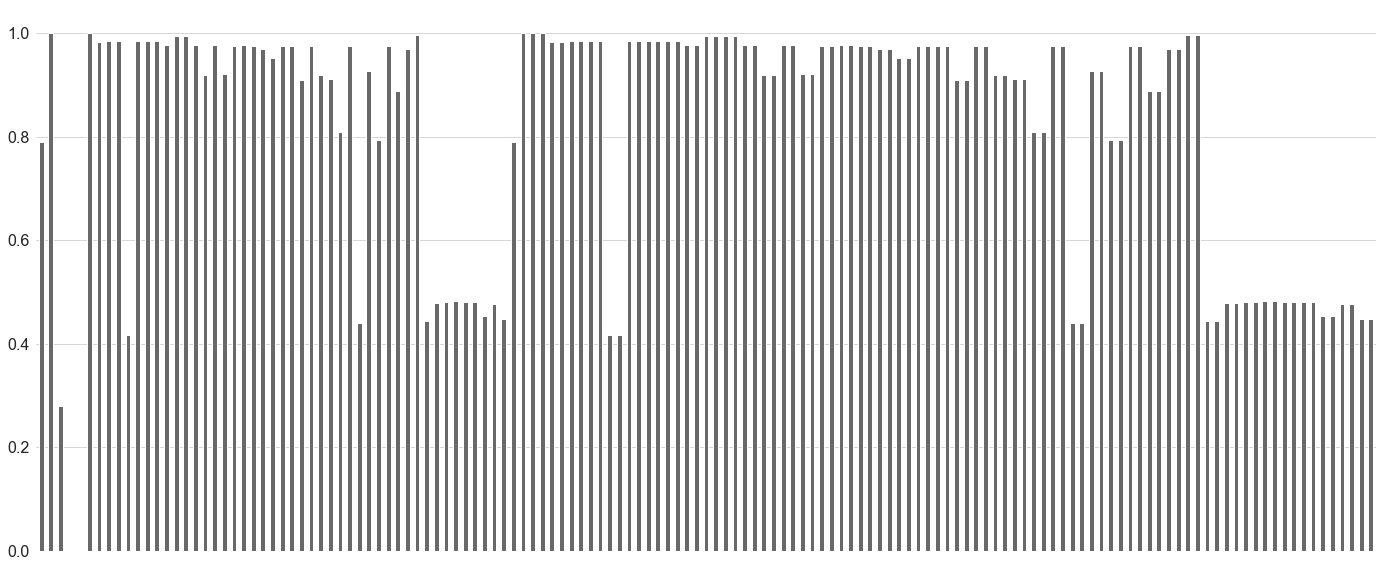

In [7]:
msno.bar(df_safe)

In [8]:
df = df_safe
features = ['Temp', 'Resp', 'Pulse','hr', 'WHITE_BLOOD_CELL_COUNT']

# fix labs
df.loc[df['WHITE_BLOOD_CELL_COUNT']>33.85,['WHITE_BLOOD_CELL_COUNT']]=33.85
# fix vitals
## temperature F to C
df.loc[df['Temp']>104, ['Temp']]=104
df.loc[df['Temp'].between(80,92), ['Temp']]=92
df.loc[df['Temp'].between(92,104),['Temp']] = df[df['Temp'].between(92,104)]['Temp'].apply(lambda x: (x-32)*5/9)
df.loc[df['Temp']<33.33333, ['Temp']]=33.33333
df.loc[df['Temp'].between(40,80), ['Temp']]=40
df.loc[df['Resp']>80,['Resp']]=80
df.loc[df['Resp']<5,['Resp']]=5
df.loc[df['Pulse']>300,['Pulse']]=300
df.loc[df['Pulse']<30,['Pulse']]=30
df.loc[df['hr']>300,['hr']]=300
df.loc[df['hr']<30,['hr']]=30



df_fixed = df.copy()

In [9]:
# median imputation

demo = ['age']
vital = ['Temp', 'Resp', 'Pulse','hr', 'SBP', 'DBP', 'SpO2','GCS', 'FiO2', 'O2_Flow']
lab = ['GLUCOSE', 'TOTAL_BILIRUBIN', 'POTASSIUM',
           'ALBUMIN', 'CALCIUM', 'SODIUM', 'WHITE_BLOOD_CELL_COUNT', 'PHOSPHORUS',
           'PROTIME_INR', 'CREATININE', 'PLATELET_COUNT', 'ALT_GPT', 'CO2',
           'ALKALINE_PHOSPHATASE', 'AST_GOT', 'PCO2', 'CHLORIDE', 'TROPONIN_I',
           'PARTIAL_THROMBOPLASTIN_TIME', 'LACTIC_ACID', 'BLOOD_UREA_NITROGEN',
           'OXYGEN_SATURATION', 'MAGNESIUM', 'FIO2', 's_rr', 's_edr', 'srr',
           's_hr', 'ds', 'mrr', 's_so2', 'x_hr_edr','x_hr_so2']




features = demo + vital + lab #['Temp','Resp','WHITE_BLOOD_CELL_COUNT','Pulse','hr']


df = df_safe.copy()
df[features] = df[features].fillna(df[features].median())
df_imp_median = df.copy()

In [10]:
df_imp_median.to_csv('../data/safe48_allvars_uva_median.csv', index=False)

In [16]:
#MICE(IterativeImputer)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



demo = ['age']
vital = ['Temp', 'Resp', 'Pulse','hr', 'SBP', 'DBP', 'SpO2','GCS', 'FiO2', 'O2_Flow']
lab = ['GLUCOSE', 'TOTAL_BILIRUBIN', 'POTASSIUM',
           'ALBUMIN', 'CALCIUM', 'SODIUM', 'WHITE_BLOOD_CELL_COUNT', 'PHOSPHORUS',
           'PROTIME_INR', 'CREATININE', 'PLATELET_COUNT', 'ALT_GPT', 'CO2',
           'ALKALINE_PHOSPHATASE', 'AST_GOT', 'PCO2', 'CHLORIDE', 'TROPONIN_I',
           'PARTIAL_THROMBOPLASTIN_TIME', 'LACTIC_ACID', 'BLOOD_UREA_NITROGEN',
           'OXYGEN_SATURATION', 'MAGNESIUM', 'FIO2', 's_rr', 's_edr', 'srr',
           's_hr', 'ds', 'mrr', 's_so2', 'x_hr_edr','x_hr_so2']




features = demo + vital + lab #['Temp','Resp','WHITE_BLOOD_CELL_COUNT','Pulse','hr']


df = df_safe.copy()
imputer = IterativeImputer(random_state=3)
df.loc[:,features] = imputer.fit_transform(df[features])

df_imp_iter = df.copy()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


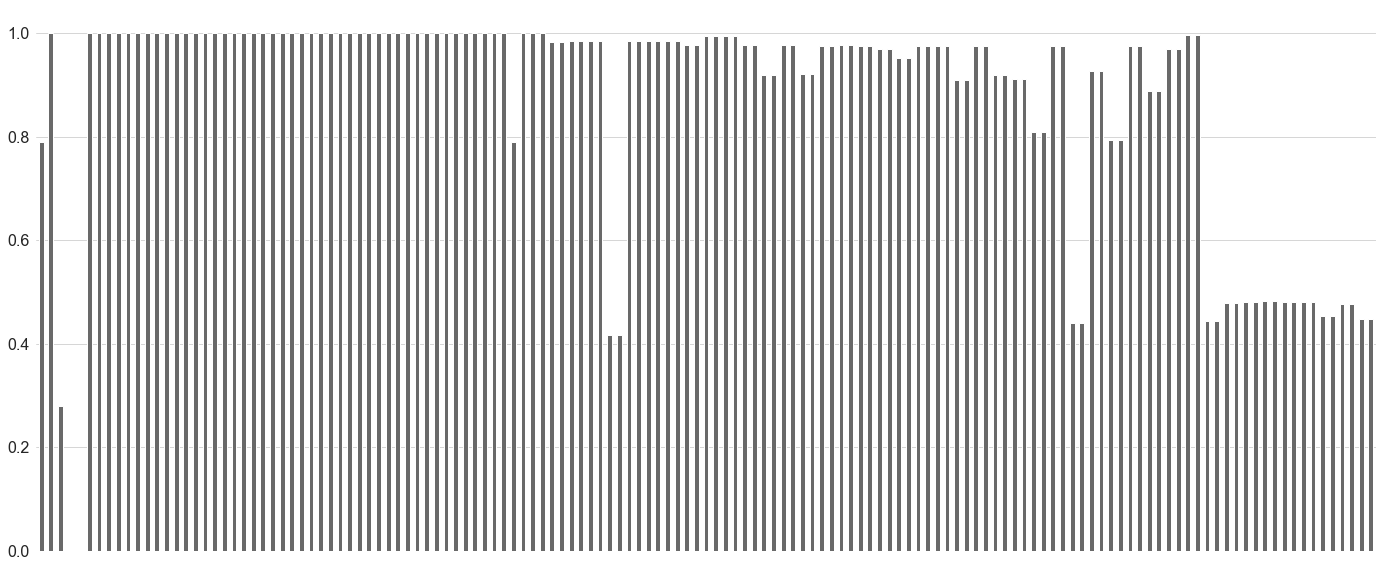

In [11]:
msno.bar(df_imp_iter)
df_imp_iter.to_csv('../data/safe48_allvars_uva_mice.csv', index=False)

In [17]:
df_imp_iter.to_csv('../data/safe48_allvars_uva_mice.csv', index=False)